# Model Tuning

This notebook includes a hyperparameter tuning and feature selection exercise for the top performing classifier. The objective is to narrow down which TML features and hyperparameters will be used in the next phase of scaling to jurisdictional scale maps.

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src/prototype')
import prepare_data as pp
import run_preds as rp
import score_classifier as score
import visualize as viz
import pandas as pd
import pickle
from datetime import datetime
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Analysis
Evaluate feature importance for the top performing MVP model (Catboost). Training with only the most important features will help to reduce overfitting and training time, while improving accuracy by removing misleading data and noise. I want to narrow down the 65 TML features to 15 with the highest feature importance. Feature importance values are normalized so that the sum of importances of all features is equal to 100.  
  
Index `0`: slope  
Index `1:3`: s1  
Index `3:13`: s2  
Index `13:77`: TML features (`77` is TML tree probability)

In [2]:
def feature_selection(model, feat_count):
    
    filename = f'../models/{model}.pkl'
    with open(filename, 'rb') as file:
        model = pickle.load(file)

    # calculate the feature importance 
    feat_import = model.get_feature_importance(prettified=True)
    feat_import = feat_import.astype({'Feature Id': int})

    # filter to only TML feats (anything after index 13)
    tml_feat_import = feat_import[feat_import['Feature Id'] >= 13]

    # get the n most important feats
    top_tml = tml_feat_import.sort_values(by='Importances', ascending=False)[:feat_count]
    
#     # which features describe 80-90% of the importance?
#     count = 40
#     tops = most_important.sort_values(by='Importances', ascending=False)[0:count]
#     percentage = tops.Importances.sum()
    
    return feat_import, top_tml


def visualize_importance(model, feature_importance, figsize):
    
    plt.figure(figsize=figsize) 

    sns.barplot(y='Feature Id', 
                x='Importances', 
                data=feature_importance,
                orient='h', 
                palette="Greens_d")
    
    plt.title(f'Feature Importance for {model}')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature');
#     plt.xticks(rotation=80, ha='right');
    
    return None
    
    

## Visualize Feature Importance

The first visualization illustrates the feature importance scores for all features used in the selected model. The second visualizations illustrates the feature importance scores for the features that explain 80-90% of the importance for the same model OR the top 15 ranked features.

## West Africa


In [3]:
df = pd.read_csv('../models/mvp_scores.csv')
starter_model = df[65:]
starter_model

,model,class,cv,train_score,test_score,roc_auc,precision,recall,f1,date
65,cat_v15_2,binary,0.804,0.9553,0.8548,0.8907,0.8631,0.9471,0.9031,2/1/23


In [4]:
feats, tml_feats = feature_selection('cat_v15_2', 15)

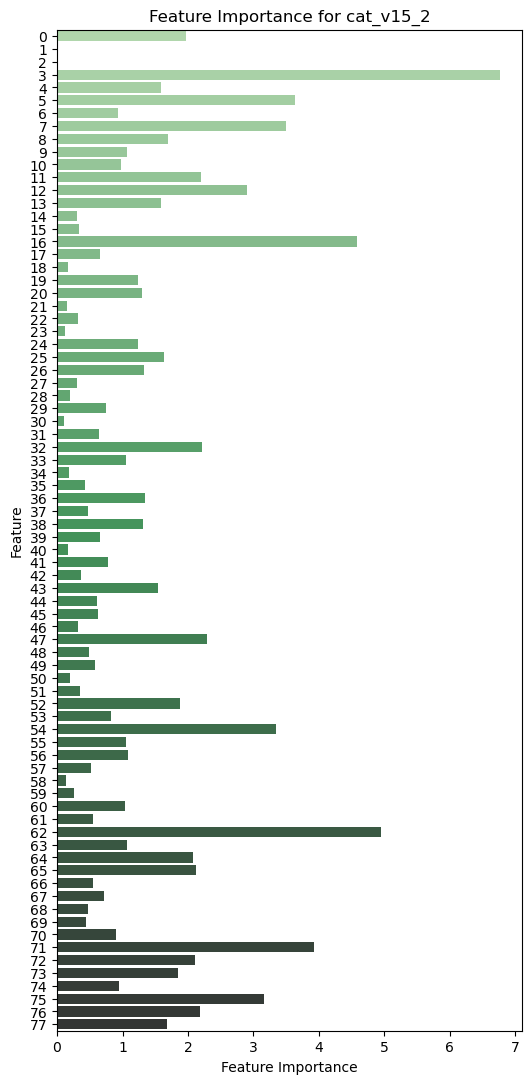

In [5]:
visualize_importance('cat_v15_2', feats, (6,13))

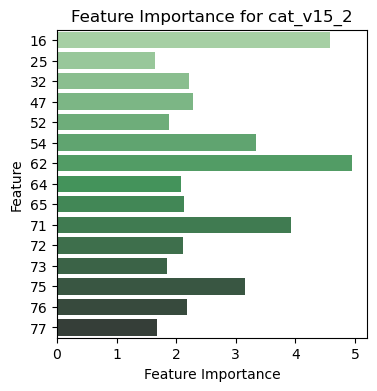

In [7]:
visualize_importance('cat_v15_2', tml_feats, (4,4))

In [8]:
list(tml_feats['Feature Id'])

[62, 16, 71, 54, 75, 47, 32, 76, 65, 72, 64, 52, 73, 77, 25]

## Central America

In [61]:
df = pd.read_csv('../models/mvp_scores.csv')
df[df['model'].str.contains('^cat_model_v10.*') == True]

,model,cv,train_score,test_score,roc_auc,precision,recall,f1,date
14,cat_model_v10_np,0.8908,0.9969,0.8518,0.9302,0.9210,0.7865,0.8485,NaN
19,cat_model_v10_nf,0.8957,0.9850,0.8262,0.9101,0.9053,0.7489,0.8197,NaN
27,cat_model_v10,0.8884,0.9972,0.8523,0.9291,0.9239,0.7847,0.8487,NaN
40,cat_model_v10,0.9073,0.9982,0.8269,0.9126,0.8695,0.7876,0.8265,11/7/22
41,cat_model_v10_nf,0.8950,0.9854,0.8293,0.9098,0.8685,0.7942,0.8297,11/7/22


## Check consistency across regions
Are the same features important for the catboost model in West Africa and South America? This section compares the top 15 most important features across regions.

In [4]:
# are the same features important for catboost in west africa?
feats_v11, tml_feats_v11 = feature_selection('cat_v11', 15)

,Feature Id,Importances
1,71,7.007700
3,16,5.586165
6,54,3.646442
7,64,3.270772
8,76,3.261219
10,62,3.126678
11,75,2.760612
12,72,2.658921
13,74,2.524666
14,13,2.363818


In [5]:
# how about south america? (v9)
feats_v9, tml_feats_v9 = feature_selection('cat_v9', 15)

,Feature Id,Importances
2,16,5.736892
4,33,3.903781
9,51,2.772934
10,62,2.696718
11,13,2.542589
12,72,2.429293
13,24,2.274026
17,71,1.643682
18,20,1.578809
19,47,1.521576


In [6]:
# what are the common best features across three regions
list(v09['Feature Id'])

[16, 33, 51, 62, 13, 72, 24, 71, 20, 47, 77, 75, 68, 25, 38]

In [7]:
list(v10['Feature Id'])

[62, 71, 74, 32, 64, 54, 33, 38, 46, 16, 77, 36, 60, 19, 13]

In [8]:
list(v11['Feature Id'])

[71, 16, 54, 64, 76, 62, 75, 72, 74, 13, 32, 77, 20, 25, 47]

In [9]:
# check latin america similarities, then including africa
first_set = set(list(v09['Feature Id'])).intersection(set(list(v10['Feature Id'])))    
result_set = first_set.intersection(set(list(v11['Feature Id'])))
print(f'common feats in central/south america: {first_set}')
print(f'common feats in all pilots: {result_set}')

common feats in central/south america: {33, 38, 71, 13, 77, 16, 62}
common feats in all pilots: {71, 77, 13, 16, 62}


# Hyperparameter Tuning
Hyperparameter tuning was informed by [Catboost Documentation](https://catboost.ai/en/docs/concepts/parameter-tuning#iterations) and using CatBoost's built in method for randomized searches. Generally speaking, Catboost's default parameters will provide a strong result, but the tuning adjustments can bring minor improvements.

In [35]:

def random_search_cat(X_train_ss, y_train, train_v):
    '''
    Performs a randomized search of hyperparameters using Catboost's built in
    random search method and plots the results, then
    and saves results to a csv file
    '''

    iterations = [int(x) for x in np.linspace(400, 1100, 10)]            # equiv to n_estimators
    depth = [int(x) for x in np.linspace(4, 10, 4)]                      # equiv to max_depth (must be <= 16)
    l2_leaf_reg = [int(x) for x in np.linspace(2, 30, 4)]
    learning_rate = [.01, .02, .03]                                      # decrease learning rate if overfitting 

    param_dist = {'iterations': iterations,
                  'depth': depth,
                  'l2_leaf_reg': l2_leaf_reg,
                  'learning_rate': learning_rate}

    # instantiate the classifier and perform Catboost built in method for random search
    cat = CatBoostClassifier(random_seed=22, verbose=False)
    randomized_search_result = cat.randomized_search(param_dist,
                                                     X=X_train_ss,
                                                     y=y_train,
                                                     n_iter=30,
                                                     cv=3,
                                                     plot=True)
        
    rs_results = {'model': 'cat', 
                  'train_v': {train_v},
                  'class': 'binary',
                  'iterations': iterations,
                  'depth': depth,
                  'l2_leaf_reg': l2_leaf_reg,
                  'learning_rate': learning_rate,
                  'results': randomized_search_result,
                  'date': datetime.today().strftime('%Y-%m-%d')}

    df = pd.DataFrame([rs_results])
    
    # write scores to new line of csv
    with open('../models/random_search.csv', 'a') as f:
        f.write('\n')
    df.to_csv('../models/random_search.csv', mode='a', index=False, header=False)
    
    # save params to json file
    
    return randomized_search_result


## West Africa
Hyperparameter tuning is done with the top 15 features as well as with the entire feature set.

In [31]:
# train a model using only 15 top feats from above
selected_feats = list(tml_feats['Feature Id'])

# update the indices since tml_feats are input individually
# subtract 13 from every val to get the original index in feats array
# feats is an array of 78, 
#
selected_feats = [feat - 13 for feat in selected_feats]
selected_feats

[49, 3, 58, 41, 62, 34, 19, 63, 52, 59, 51, 39, 60, 64, 12]

In [50]:
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=selected_feats, 
                    verbose=True)

In [33]:
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)

In [29]:
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v15_fs')

In [36]:
## now execute the random search
rs = random_search_cat(X_train_ss, y_train, 'v15_fs')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3578488809
bestIteration = 476

0:	loss: 0.3578489	best: 0.3578489 (0)	total: 3.4s	remaining: 1m 38s

bestTest = 0.3588610535
bestIteration = 476

1:	loss: 0.3588611	best: 0.3578489 (0)	total: 7.2s	remaining: 1m 40s

bestTest = 0.3633417579
bestIteration = 632

2:	loss: 0.3633418	best: 0.3578489 (0)	total: 11.1s	remaining: 1m 39s

bestTest = 0.3642340982
bestIteration = 632

3:	loss: 0.3642341	best: 0.3578489 (0)	total: 15s	remaining: 1m 37s

bestTest = 0.3442098435
bestIteration = 632

4:	loss: 0.3442098	best: 0.3442098 (4)	total: 18.9s	remaining: 1m 34s

bestTest = 0.3482846752
bestIteration = 865

5:	loss: 0.3482847	best: 0.3442098 (4)	total: 24.2s	remaining: 1m 36s

bestTest = 0.3805266705
bestIteration = 865

6:	loss: 0.3805267	best: 0.3442098 (4)	total: 29.5s	remaining: 1m 37s

bestTest = 0.3291072863
bestIteration = 865

7:	loss: 0.3291073	best: 0.3291073 (7)	total: 35.1s	remaining: 1m 36s

bestTest = 0.3420669084
bestIteration = 1021

8:	loss: 0.3420669	best: 0.32

In [52]:
rs['params']

{'depth': 10, 'l2_leaf_reg': 11, 'iterations': 1100, 'learning_rate': 0.02}

In [46]:
# now train a model with the best parameters
# manually added to script - will have to adapt moving forward
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=selected_feats, 
                    verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v15_tuned')

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Training data includes 557 plots.
Class count {0.0: 30139, 1.0: 79033}


In [42]:
## for binary classification, use scale_pos_weight 
## for multi class classification, use class_weights
# to get the scale pos weight you would use sum(negative class) // sum(positive class)
# this will be the weight for class 1
# https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance
class_count = {0.0: 30139, 1.0: 79033}
scale_pos = class_count[0] / class_count[1]
scale_pos

0.3813470322523503

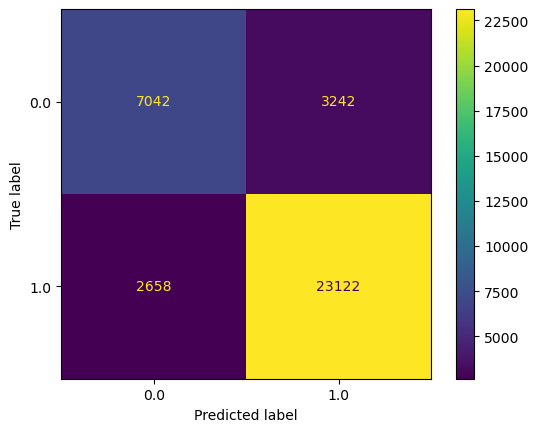

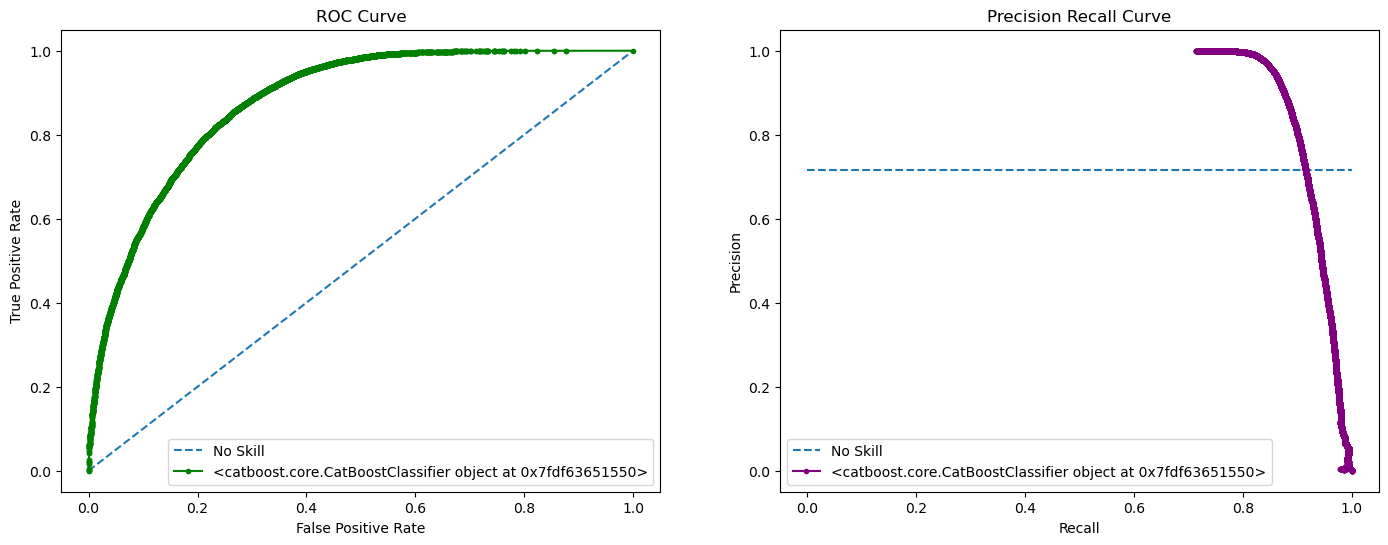

In [49]:
viz.cm_roc_pr('cat_v15_tuned', y_test, pred, probs_pos)

## Central America

In [136]:
# use central america training data
X, y = pp.create_xy((14, 14), ['v03', 'v04', 'v10'], drop_prob=False, drop_feats=False, verbose=False)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y)

Plot id 04003 has no cloud free imagery and will be removed.
Plot id 04005 has no cloud free imagery and will be removed.
Plot id 04007 has no cloud free imagery and will be removed.
Plot id 04009 has no cloud free imagery and will be removed.
Plot id 10043 has no cloud free imagery and will be removed.
Plot id 10067 has no cloud free imagery and will be removed.
Baseline: 0.483
The data has been scaled to -1.0000000000000002, 1.0000000000000002


In [138]:
iterations = [int(x) for x in np.linspace(200, 1100, 10)]            # equiv to n_estimators
depth = [int(x) for x in np.linspace(4, 10, 4)]                      # equiv to max_depth (must be <= 16)
l2_reg = [int(x) for x in np.linspace(2, 30, 4)]
learning_rate = [.01, .02, .03]                                      # decrease learning rate if overfitting 

param_dist = {'iterations': iterations,
              'depth': depth,
              'l2_leaf_reg': l2_reg,
              'learning_rate': learning_rate}

# instantiate the classifier and perform random search
cat = CatBoostClassifier(random_seed=22, verbose=False)

rds = RandomizedSearchCV(estimator=cat,
                        param_distributions=param_dist, 
                        n_iter=30,
                        cv=3,
                        random_state=22)

# Achieves 0.908
rds.fit(X_train_ss, y_train)
rds_best = rds.best_params_
print(f"The best parameters are {rds.best_params_} with a score of {rds.best_score_}")

The best parameters are {'learning_rate': 0.03, 'l2_leaf_reg': 30, 'iterations': 1100, 'depth': 4} with a score of 0.9084283317567475


In [139]:
# now fit classifier with best params and get all scores
cat_best_params = CatBoostClassifier(random_seed=22,
                                     learning_rate=0.03,
                                     l2_leaf_reg=30,
                                     iterations=1100,
                                     depth=4,
                                     verbose=False)

cat_best_params.fit(X_train_ss, y_train) 

# save trained model
filename = f'../models/cat_model_v10tuned.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

score.print_scores(cat_best_params, X_train_ss, X_test_ss, y_train, y_test)

cv: 0.9084
train: 0.9783
test: 0.8278
roc_auc: 0.9134
precision: 0.8702
recall: 0.7888
f1: 0.8275


In [3]:
original_model

,model,cv,train_score,test_score,roc_auc,precision,recall,f1
29,cat_model_v10,0.8884,0.9972,0.8523,0.9291,0.9239,0.7847,0.8487


## Conclusions

### Round 3
The top ranked 15 TML features for the `cat_v15_2` model are `[62, 16, 71, 54, 75, 47, 32, 76, 65, 72, 64, 52, 73, 77, 25]`. The TML predictions (index 77) barely made the cut and are the 14th most important feature.

After performing CatBoost's Randomized Search method on training data that only included the selected features, the following parameters were considered the best `{'depth': 10, 'l2_leaf_reg': 11, 'iterations': 1100, 'learning_rate': 0.02}`. 

Three models were deployed, including `cat_v15_2`, `cat_v15_fs` and `cat_v15_tuned` and the results were compared visually. `cat_v15_2` is a bare bones model with no tuning or feature manipulation. `cat_v15_fs` used the top 15 selected features and `cat_v15_tuned` used specific hyperparameters with the top 15 selected features.




### Round 2
- There are commonalities across regions. In Latin America (Cental + South) there are 7 common features in the top 15 most important TML features `{13, 16, 33, 38, 62, 71, 77}`. All three regions share 5 of the most important features `{13, 16, 62, 71, 77}`. 
- For Central America, slope and s2 were also important predictors.
- Hyperparameter tuning indicated the best parameters are `{'learning_rate': 0.03, 'l2_leaf_reg': 30, 'iterations': 1100, 'depth': 4}`
- Fitting a CatBoost Classifier with selected hyperparameters did reduce overfitting.

### Round 1
- Fitting the CatboostClassifier with the top 15 TML features rather than all 65 only brought minor improvements in accuracy.
- The feature selection exercise revealed that different features are important for different regions.
- Index 7 (s2) and 67 (TML feat) ranked highly across all three regions.
- Index 77 (TML tree probability) had low importance, which is expected considering it is derived from the other features. 
- Fitting CatboostClassifier with the best features and best parameters resulted in improvements between .01 - .1% across accuracy metrics.